## Name: Karma Tarap
### CSCI E-89C Deep Reinforcement Learning  
### Part II of Final

In [1]:
import random
import time
import pickle

from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns

from keras import layers
from keras import models
from keras.layers import Dropout
from keras.optimizers import Adam

from sklearn.cluster import KMeans
from pytest import approx

Using TensorFlow backend.


## Problem 1 (5 points)

Consider the optimal selection of a treatment. Suppose that there are 4 types of treatments available. The outcome of each treatment is either 1 (recovery) or 0.   

Let's denote the outcome by $R_t$, then $R_t|(A_t=a)$ follows $\text{Bernoulli}(p_a)$ with $a\in\{1,2,3,4\}$ and all $p_a\in [0,1]$, where $A_t$ denotes the action on time step $t=1,2,3,\ldots$. 

Assume that $p_1=0.05$, $p_2=0.15$,  $p_3=0.55$, $p_4=0.85$, which are not known to the doctor. This is the 4-armed Bandit Problem with Bernoulli distributions. The rewards $R_t$ are 0's and 1's. Please notice that $P\{R_t=1|A_t=a\}=p_a$. Also, the expectation $E\left[R_t|A_t=a \right]=p_a$.

Develop the Upper-Confidence-Bound Action Selection algorithm for the problem of selecting the best treatment and report the following graphs:   

(a) Run the algorithm for $t=1,2,3,\ldots,400$ and plot $R_t$'s v.s. $t$ for one simulation. Use $c=0.15$.   
(b) Run 100 trajectories in (a); and for each time step $t$ plot the average of $R_t$'s from all 100 trajectories at this particular time (please do not average all returns over time - we want to see how the learning progresses over time). Use $c=0.15$.   
(c) Using trajectories you obtained in (b), for each time step $t$, plot the proportion  (out of 100) of times the best action (action $a=4$) was selected by the doctor. Again, use $c=0.15$.

In [2]:
def argmax(q):
    """ Argmax for numpy arrays that break ties randomly
    Args:
        q (numpy array): 
    Returns:
        (int): Index of q containing the maximal value
        In the event of a tie, randomly return an index
    """
    return np.random.choice(np.flatnonzero(q == q.max()))


assert argmax(np.array([3,4,5,6,7,3])) == 4 
assert argmax(np.array([9,4,5,6,7,3])) == 0
assert argmax(np.array([1,4,5,6,9,9])) in (4,5)

In [3]:
class Environment:
    def __init__(self):
        self.time = 1
        # True Probability of reward of each action
        self.p = (0.05, 0.15, 0.55, 0.85)
    
    def admissible_actions(self):
        """Return list of admissible actions"""
        return list(range(len(self.p)))

    def get_reward(self, action):
        """Samples rewards from a binomial distribution with probability p"""
        self.time += 1
        return np.random.binomial(1, self.p[action])

In [4]:
class UCBAgent:
    """Agent that selects actions based on Upper Confidence Bound"""
    def __init__(self, k, env):
        self.current_reward = 0.0
        self.current_action = []
        self.Nt = np.ones(k)
        self.Qt = np.zeros(k)
        
    def step(self, env, c = 0.15):
        actions = env.admissible_actions()
        At = self.select_action(env, actions, c)
        Rt = env.get_reward(At)
        
        self.Nt[At] = self.Nt[At]+1
        self.Qt[At] = self.Qt[At]+(1/self.Nt[At])*(Rt-self.Qt[At])
        
        self.current_action = At
        self.current_reward = Rt
        
    def select_action(self, env, actions, c):  
        """UCB action selection. See Sutton et al. section 2.6"""
        action_selected = argmax(self.Qt + c * np.sqrt(np.log(env.time) / self.Nt))
        return action_selected

In [5]:
def ucb_rewards_hist(T = 400, k = 4, c = .15):
    """Return rewards history of taking T steps with UCB Agent"""
    env = Environment()
    agent = UCBAgent(k, env)
    rewards = []
    while env.time <= T:
        agent.step(env,c=c)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)

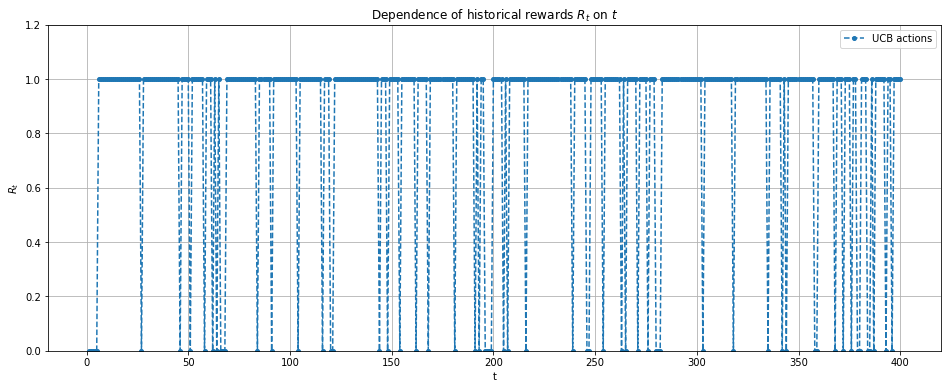

In [6]:
np.random.seed(167)
T = 400

plt.figure(figsize=(16,6))
plt.plot(range(1,T+1),ucb_rewards_hist(T), linestyle='--', marker='o', markersize=4, label='UCB actions')
plt.xlabel("t")
plt.ylabel("$R_t$")
plt.title('Dependence of historical rewards $R_t$ on $t$')
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

In [7]:
class BanditAgent:
    """Epsilon greedy agent"""
    def __init__(self, k):
        self.current_reward = 0.0
        self.current_action = []
        self.Nt = np.zeros(k)
        self.Qt = np.full(k, fill_value=0.)

    def step(self, env, epsilon = 0.05):
        actions = env.admissible_actions()
        At = self.select_action(env, actions, epsilon)
        Rt = env.get_reward(At)
        
        self.Nt[At] = self.Nt[At]+1
        self.Qt[At] = self.Qt[At]+(1/self.Nt[At])*(Rt-self.Qt[At])
        
        self.current_action = At
        self.current_reward = Rt
        
    def select_action(self, env, actions, epsilon):
        """Greedy actions selected with probability 1-epsilon"""
        rand_num = random.uniform(0,1)
        if rand_num <= 1-epsilon:
            action_selected = argmax(self.Qt)
        else:
            action_selected = random.choice(actions)
        return action_selected

In [8]:
def bandit_rewards_hist(T = 10, k = 4, epsilon = 0.05):
    """Returns rewards history of taking T steps with epsilong greedy Agent"""
    env = Environment()
    agent = BanditAgent(k)
    rewards = []
    while env.time <= T:
        agent.step(env,epsilon)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)

In [9]:
T = 400
epochs = 100

In [10]:
def avg_rewards(T=400, epochs=100, f=ucb_rewards_hist, *args, **kwargs):
    """Returns average reward for T steps over epochs"""
    np.random.seed(1234)
    all_rewards = np.asarray([f(T, *args, **kwargs) for _ in range(epochs)])
    return (np.mean(all_rewards, axis=0))

In [11]:
bandit_avg_rewards = avg_rewards(f=bandit_rewards_hist, epsilon=0.05)

In [12]:
ucb_avg_rewards_1 = avg_rewards(c=0.05)

In [13]:
ucb_avg_rewards_2 = avg_rewards(c=1)

In [14]:
ucb_avg_rewards_3 = avg_rewards(c=2)

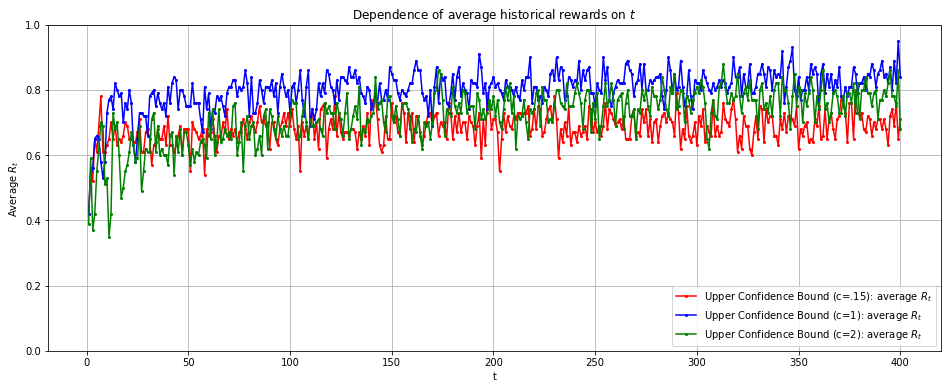

In [15]:
plt.figure(figsize=(16,6))
plt.plot(range(1,T+1),ucb_avg_rewards_1, linestyle='-', marker="o",color = "r", markersize=2, label='Upper Confidence Bound (c=.15): average $R_t$')
plt.plot(range(1,T+1),ucb_avg_rewards_2, linestyle='-', marker="o",color = "b", markersize=2, label='Upper Confidence Bound (c=1): average $R_t$')
plt.plot(range(1,T+1),ucb_avg_rewards_3, linestyle='-', marker="o",color = "g", markersize=2, label='Upper Confidence Bound (c=2): average $R_t$')

plt.xlabel("t")
plt.ylabel("Average $R_t$")
plt.title('Dependence of average historical rewards on $t$')
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc = 'lower right')
plt.show()

We can see that using `c` of 1 and 2 both out perform a `c`of 0.15. The `c` parameter determines the confidence level.

In [16]:
def ucb_actions_hist(T = 400, k = 4, c = 0.15):
    """Returns history of actions taken"""
    env = Environment()
    agent = UCBAgent(k, env)
    actions = []
    while env.time <= T:
        agent.step(env, c)
        actions.append(agent.current_action)
    return np.asarray(actions)

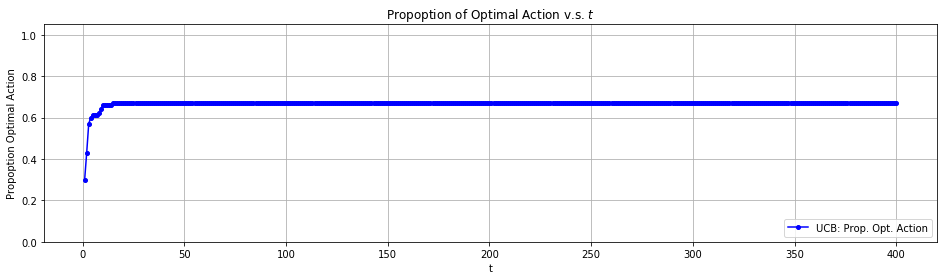

In [17]:
np.random.seed(167)
T = 400
epochs = 100

all_actions = np.asarray([ucb_actions_hist(T) for _ in range(epochs)])

#actions are 0 indexed so 3 is optimal action
best_actions = (all_actions == 3)*1
prop_actions = np.sum(best_actions, axis=0) / epochs

plt.figure(figsize=(16,4))
#plt.plot(range(1,T+1),np.transpose(all_actions), linestyle='--', marker=None, markersize=4)
plt.plot(range(1,T+1),prop_actions, linestyle='-', marker="o",color = "b", markersize=4, label='UCB: Prop. Opt. Action')
plt.xlabel("t")
plt.ylabel("Propoption Optimal Action")
plt.title('Propoption of Optimal Action v.s. $t$')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(loc = 'lower right')
plt.show()

## Problem 2 (5 points)

Consider Environment that has five states: 1, 2, 3, 4, and 5. Possible transitions are: (1) 1->1, 1->2; (2) 2->1, 2->2, 2->3; (3) 3->2, 3->3, 3->4; (4) 4->3, 4->4, 4->5; (5) 5->4, 5->5.

Actions of the Agent are decoded by -1, 0, and +1, which correspond to its intention to move left, stay, and move right, respectively. The Environment, however, does not always respond to these intentions exactly, and there is 10% chance that action 0 will result in moving to the right (if moving to the right is admissible), and -1 action will result in staying - in other words, there is a "west wind." More specifically, the non-zero transition probabilities $p(s^\prime,r|s,a)$ are  

$p(s^\prime=1,r=0|s=1,a=0)=0.9, p(s^\prime=2,r=0|s=1,a=0)=0.1$,  
$p(s^\prime=2,r=0|s=1,a=+1)=1$,<br>

$p(s^\prime=1,r=0|s=2,a=-1)=0.9, p(s^\prime=2,r=0|s=2,a=-1)=0.1$,<br>
$p(s^\prime=2,r=0|s=2,a=0)=0.9,p(s^\prime=3,r=-10|s=2,a=0)=0.1$,<br>
$p(s^\prime=3,r=-10|s=2,a=+1)=1$,<br>

$p(s^\prime=2,r=0|s=3,a=-1)=0.9,p(s^\prime=3,r=-10|s=3,a=-1)=0.1$,<br>
$p(s^\prime=3,r=-10|s=3,a=0)=0.9,p(s^\prime=4,r=0|s=3,a=0)=0.1$,<br>
$p(s^\prime=4,r=0|s=3,a=+1)=1$,<br>

etc.

Further, we assume that whenever the process enters state 3, the Environment generates reward = -10. In all other cases the reward is 0. For example, transition 2->3 will result in reward -10, transition 3->3 will result in reward -10, transition 3->2 will result in reward 0, transition 2->2 will result in reward 0, etc.



Further, assume that the agent does not know about the wind or what rewards to expect. It chooses to stay in all states, i.e. the policy is
$\pi(-1|1)=0, \pi(0|1)=1, \pi(+1|1)=0$,<br>
$\pi(-1|2)=0, \pi(0|2)=1, \pi(+1|2)=0$,<br>
$\pi(-1|3)=0, \pi(0|3)=1, \pi(+1|3)=0$,<br>
$\pi(-1|4)=0, \pi(0|4)=1, \pi(+1|4)=0$,<br>
etc.

Please estimate the state-value function using 2-step Temporal Difference (TD) prediction. Let’s use $\gamma=0.9$ and run the episodes for $T=100$.


In [18]:
class Environment:
    def __init__(self, S0 = 1):
        self.time = 0
        self.state = S0

    def admissible_actions(self):
        """Returns admissable actions which is left, right, stay, except for terminal states"""
        A = list((-1,0,1))
        if self.state == 1: A.remove(-1)
        if self.state == 5: A.remove(1)
        return A
    
    @property
    def check_state(self):
        return self.state

    def get_reward(self, action):
        self.time += 1
        move = action
        if self.state > 1 and move > -1:
            move = np.random.choice([move-1, move],p=[0.1,0.9])
        self.state += move
        if self.state == 3:
            reward = -10
        else:
            reward = 0
        return reward

In [19]:
class Agent:
    def __init__(self, A0=0):
        self.current_reward = 0.0
        self.current_action = A0
        
    def step(self, env):
        action_selected = 0 #policy is always stay
        reward = env.get_reward(action_selected)            
        self.current_reward = reward

In [20]:
def gen_episode(S0, A0, T=10):
    """Returns generated episodes in SAR format"""
    env = Environment(S0)
    agent = Agent(A0)
    states = []
    actions = []
    rewards = []
    for t in range(T+1):
        states.append(env.state)
        agent.step(env)
        actions.append(agent.current_action)
        rewards.append(agent.current_reward)
    return [states, actions, rewards]

In [21]:
def nstepTD(n=2, alpha=0.01, gamma=0.9, T=100, nepisodes=5000):
    """ nstepTD to estimate state values
    Args:
        n (int): n step TD
        T (int): Steps, here patients per hospital
        alpha (float): learning rate
        gamma (float): discount rate
        nepisodes (int): number of experiments to run
    Returns:
        v_hat (numpy array)
    """
    V = np.zeros(5)
    
    for k in range(nepisodes):
        S0 = np.random.randint(low=1, high=6, size=1)[0]
        env = Environment(S0)
        A0 = 0
        episode = gen_episode(S0, A0, T)
        for t in range(0,T-n+1):
            S = episode[0][t]
            Sn = episode[0][t+n]
            G = 0
            for tau in reversed(range(t,t+n)):
                R = episode[2][tau] 
                G = R + gamma*G
            G = G + gamma**n*V[Sn-1]
            V[S-1] = V[S-1] + alpha*(G - V[S-1])  
    return V

V = nstepTD()
print("state-value function:")
print(V)

state-value function:
[  0.           0.         -42.55199981 -28.97910126 -13.26004747]


## Problem 3 (5 points)

In this problem, we consider the optimization of hospital patient flow using the Markov Decision Process. We assume that the hospital can hold 300 patients at most.

Further, we introduce three states as follows:   

"Low" if number of patients is in $[0,100)$   
"Medium" if number of patients is in $[101,200)$   
"High" if number of patients is in $[201,300]$    

Please notice that this aggregation is an improtant step as it allows one to accuratly estimate the transition probabilities from state to state using the database that tracks journeys of patients through the hospital from arrival to discharge.



One time step corresponds to one day and the administration of the hospital can select the following actions:

If the hospital has "Low" number of patients, then $a \in \{0\}$, where $0$ indicates that no patient will be released early.   
If the hospital has "Medium" number of patients, then $a \in \{0,1\}$, i.e. besides action $a=0$, only one additional action is admissible, namely $1$. This action corresponds to releasing $10$ patients early.   
If the hospital has "High" number of patients, then $a \in \{0,1,2\}$, i.e. besides action $a=0$, two additional actions, namely $1$ and $2$, are admissible. Action $a=1$ again corresponds to releasing $10$ patients early, while action $2$ indicates releasing $20$ patients early.  
   
<br>
        
Further, assume that we found the transition probabilities $p(S_{t+1}=s^\prime|S_t=s,A_t=a)$ to be (for a data-driven estimates refer, for instance, to "Markov Decision Process Model for Optimisation of Patient Flow" by Clissold, J. Filar, S. Qin, and D.Ward, 21st International Congress on Modelling and Simulation, Gold Coast, Australia, 29 Nov to 4 Dec 2015):   

$p(S_{t+1}=s^\prime|S_t=s,A_t=0)=\begin{bmatrix} 
0.8 & 0.2 & 0 \\
0.25 & 0.7 & 0.05\\
0.01 & 0.25 & 0.74\\
\end{bmatrix}$    

Here, we use the Markov Chain convention with $s$ being the row index (in the order from "Low" to "Hight"), and $s^\prime$ being the column index.    
For example, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=0)=0.05$ and $p(S_{t+1}=\text{"Medium"}|S_t=\text{"Low"},A_t=0)=0.2$.

If, however, the hospital decides to release $10$ patients early, i.e. $A_t=1$, the probability of moving to a "lower" hospital occupancy level are now larger, while the probability of moving to a "higher" state are smaller:  

$p(S_{t+1}=s^\prime|S_t=s,A_t=1)=\begin{bmatrix} 
- & - & - \\
0.25+0.1 & 0.7-0.09 & 0.05-0.01\\
0.01+0.01 & 0.25+0.09 & 0.74-0.1\\
\end{bmatrix}$ 

where same $s, s^\prime$ index convention is used. Plase notice that in state $s=\text{"Low"}$ action $A_t=1$ is unavailable resuting in missing probabilities (denoted by "-") in the matrix above. On the other hand, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=1)=0.05-0.1$, for example.

Finally, if the decision maker selects to reaease $20$ patients early, i.e. $A_t=20$, then   

$p(S_{t+1}=s^\prime|S_t=s,A_t=2)=\begin{bmatrix} 
- & - & - \\
- & - & -\\
0.01+0.02 & 0.25+0.18 & 0.74-0.2\\
\end{bmatrix}.$   
   
<br><br>
        
The reward $R_{t+1}$ obtained as a result of action $A_t$ is defined as follows:   
$R_{t+1}=\frac{1}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"Low"}\}}\cdot 49.5+\mathbb{1}_{\{S_{t+1}=\text{"Medium"}\}}\cdot 150.5+\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot 255.5 + A_t\cdot (-10)\right]+\frac{9}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot (-30)\right]$.

Here, the first term $\frac{1}{10}\left[\ldots\right]$ is related to the direct profit of the hospital, while the second term $\frac{9}{10}\left[\ldots\right]$ is associated with the inconvenience of patients, risk of refusal for admission of new patients, and the reputation of the hospital.

<br>
Using this information, please find the optimal policy for the decision making via Double Q-learning. Use $\gamma=0.9$. Please treat this problem as a continuing task.

In [22]:
class Environment:
    actions = list(range(3))
    states = list(range(3))
    
    _a0 = [(.8, .2, .0),(.25, .7, .05),(.01, .25, .74)]
    _a1 = [(None, None, None), (0.25+0.1, 0.7-0.09, 0.05-0.01), (0.01+0.01, 0.25+0.09, 0.74-0.1)]
    _a2 = [(None, None, None), (None, None, None), (0.01+0.02, 0.25+0.18, 0.74-0.2)]
    transtion_probability = [_a0, _a1, _a2]
    
    def __init__(self, S0 = 0):
        self.state = S0
        self.time = 0

    def admissible_actions(self, state=None):
        if state is None:
            state = self.state
        return self.actions[:state+1]

    def get_reward(self, action):
        _p = self.transtion_probability[action][self.state]
        next_state = np.random.choice(self.actions, p=_p)
        reward = .1 * ((next_state ==0 * 49.5 ) + (next_state == 1  * 150.5) + (next_state == 2 *255.5) + (action * -10)) + .9 * (next_state == 2 * -30)
        return reward
    
    def transitions(self, new_state, state, action):
        """Returns transition probability of known action, state, new action"""
        # For checking purposes only
        return self.transtion_probability[action][state][new_state]
    
    
env = Environment()

# Checks based on problem description
assert env.transitions(2,1,0) == .05 
assert env.transitions(1,0,0) == .2 
assert env.transitions(2,1,1) == 0.05-0.01 
assert env.transitions(0,0,1) == None

In [23]:
# Sanity check to ensure transition probabilities sum to 0 or 1  

ass_ = np.zeros((len(env.actions),len(env.states), len(env.states)))
for s in env.states:
    for a in env.admissible_actions(s):
        for s_ in env.states:
            ass_[a, s, s_] = env.transitions(s_, s, a) #env.get_reward(a, s_)
        
for a in env.actions:
    for s in env.states:
        assert (sum(ass_[a,s,:])) in (0,1)

In [24]:
class Agent:
    def __init__(self, A0=0):
        self.current_reward = 0.0
        self.current_action = A0

    def step(self, env, action):
        action_selected = action
        if env.time == 0:
            action_selected = self.current_action
        reward = env.get_reward(action_selected)            
        self.current_action = action_selected 
        self.current_reward = reward

In [25]:
def q_argmax(q_values, admissable):
    """argmax with random tie-breaking (np.argmax always takes the first)
       Also allow for ignoring an index
    Args:
        q_values (Numpy array): the array of action-values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if i in admissable:
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

    return np.random.choice(ties)

In [26]:
def epsilon_greedy(Q, actions, epsilon = 0.05):
    """ Epsilon greedy implementation that supports permissible actions
    Args:
        Q (numpy array): State-Action values for a state
        actions (list): permissible actions for given state
        epsilon: probability for exploration
    Returns:
        action(int): next action 
    """
    if random.random() > epsilon:
        return q_argmax(Q, actions)
    return np.random.choice(actions)

In [27]:
def avg_q(state, q1, q2):
    """ Average state action values for given action
    Args:
        state (int): current state
        q1 (numpy array): state action values under Q1
        q2 (numpy array): state action values under Q2
    Returns:
        Average Q (numpy array)
    """
    return (q1[state] + q2[state])/2

In [28]:
def double_Q(T=300, alpha = .01, gamma=.9, nepisodes=5000):
    """ Double Q-learning to estimate state action values
    Args:
        T (int): Steps, here patients per hospital
        alpha (float): learning rate
        gamma (float): discount rate
        nepisodes (int): number of experiments to run
    Returns:
        Q_hat Average Q values (numpy array)
    """
    # 3 states and 3 actions
    Q1 = np.zeros((3, 3))
    Q2 = np.zeros((3, 3))

    for i in range(300):
        S0 = np.random.randint(low=1, high=3, size=1)[0]
        env = Environment(S0)
        A0 = np.random.choice(env.admissible_actions())
        agent = Agent(A0)

        for _ in range(T):
            prev_state = env.state
            temp_q = avg_q(prev_state, Q1, Q2)
            actions = [a+1 for a in env.admissible_actions()]

            action = epsilon_greedy(temp_q, actions)
            agent.step(env, action)

            if random.random() > 0.5:
                Q1[prev_state, agent.current_action] += alpha * (agent.current_reward + gamma * Q2[env.state][q_argmax(Q1[env.state], actions)] - Q1[prev_state, agent.current_action]) 
            else:
                Q2[prev_state, agent.current_action] += alpha * (agent.current_reward + gamma * Q1[env.state][q_argmax(Q2[env.state], actions)] - Q2[prev_state, agent.current_action]) 

    return (Q1 + Q2)/2

In [29]:
Q_star = double_Q()
Q_star

array([[  0.        ,   0.        ,   0.        ],
       [  0.02681422,  -0.96300086,   0.        ],
       [ -8.97489125,  -9.97505129, -10.97311077]])

In [30]:
pi = np.argmax(Q_star, axis=1)

In [31]:
for s, occupancy in enumerate(("low", "medium", "high")):
    print(f"For {occupancy} occupancy hospitals, the optimal policy is to discharge {argmax(pi[s])*10} patients")

For low occupancy hospitals, the optimal policy is to discharge 0 patients
For medium occupancy hospitals, the optimal policy is to discharge 0 patients
For high occupancy hospitals, the optimal policy is to discharge 0 patients


## Problem 4 (10 points)

In this problem we will develop an algorithm for approximating state values using Deep Neural Network (NN). We consider images of size 28x28, which can be treated as vectors of 784 features: ${\bf x}=(x_1,x_2,\ldots,x_{784})^T$.

Please load the observations of features ${\bf x}(S_t)$, $t=0,1,\ldots$ ('images' variable), actions $A_t$, $t=0,1,\ldots$ ('actions' variable), and rewards $R_t$, $t=1,2,\ldots$ from the 'markov_decision_process.pkl' file. Please notice that in each state $s\in \mathcal{S}$, the set of admissible actions is $\mathcal{A}(s)=\{0,1,2\}$. Here, "0" states for no treatment and "1" and "2" are two treatments of different types. We assume that this is a Markov Decision Process, that is, the joint distribution of the next state $S_{t+1}$ and reward $R_{t+1}$ depens on the pair of current state and action $(S_t, A_t)$ only.

These rewards were obtained under uniform policy $\pi$, that is, actions were selected at random from the action space $\mathcal{A}(s)$. Please develop a 1-step TD prediction algorithm with approximation via a Deep NN to evaluate state values $v_\pi(s)$ under this pilicy $\pi$. Please use the vector of fetures ${\bf x}(S_t)$ as an input to the NN. The output of the NN should be the state-values $\hat{v}(S_t,{\bf w})$. Please feel free to use either feedforward fully connected NN or Convolutional NN.

Please 
- train the NN in mini-batches of size 128, that is, the weights ${\bf w}$ will be updated every 128 time steps
- update the target $R_{t+1}+\gamma\hat{v}(S_{t+1},{\bf w})$ every 1280 time steps only, that is, not the most recent weights should be used to evaluate this taget  - this usually guarantees a better stability of the algorithm

Once the training is finished, please pick 24 images at random and display them together with the estimated state values in the titles. 

In [32]:
with open('markov_decision_process.pkl', 'rb') as f:
    images, actions, rewards = pickle.load(f)

In [33]:
rewards[:10]

[-0.799458078949402,
 0,
 -5.432059103108984,
 -4.628510222149191,
 0,
 -3.235158807235235,
 0,
 -5.160826167764449,
 -5.560819733889062,
 0]

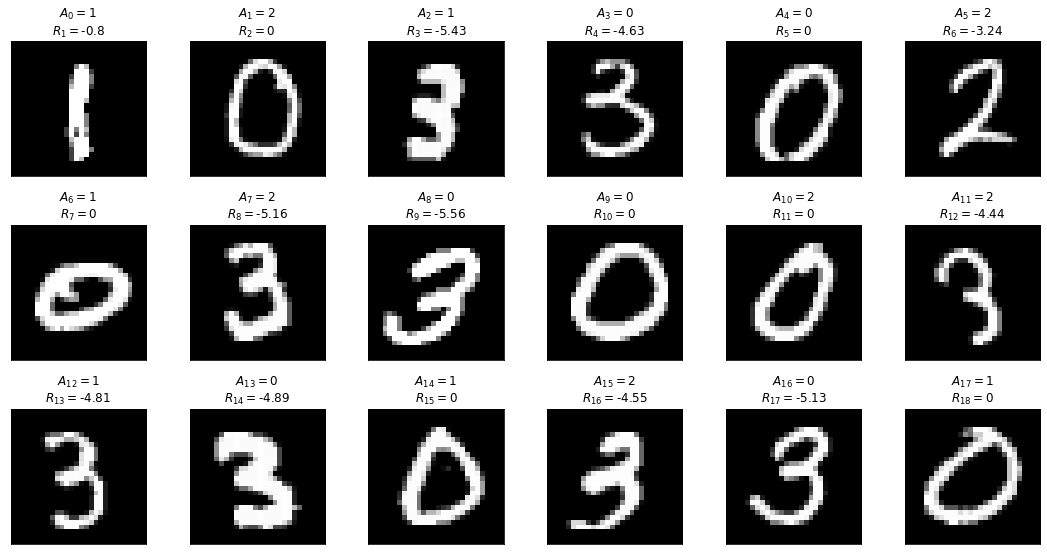

In [34]:
k = 0
fig = plt.figure(figsize=(15,8))
for t in range(18):
    k += 1
    plt.subplot(3,6,k)
    plt.tight_layout()
    plt.imshow(images[t], cmap='gray', interpolation='none')
    plt.title("$A_{" + str(t) + "}=$"+str(actions[t])+"\n$R_{" + str(t+1) + "}=$"+str(round(rewards[t],2)))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [35]:
image_dim = images.shape
Xs = images.reshape(image_dim[0], image_dim[1]*image_dim[2])
# rescale images
Xs /= 255

In [36]:
Xs.shape

(50000, 784)

In [37]:
def define_model():
    model = models.Sequential()
    model.add(layers.Dense(512, activation="relu", input_shape=(784,)))                          
    model.add(Dropout(0.2))
    model.add(layers.Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    model.add(layers.Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1))

    model.summary()
    opt = Adam(learning_rate=0.0001) #Much smaller learning rate
    model.compile(loss='mse', metrics=['mse'], optimizer=opt)
    return model

In [38]:
model = define_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [39]:
γ=.97
n_epochs=5
batch_size = 1280
mini_batch_size = 128
batches = len(images) // batch_size
for k in range(batches):
    times = np.arange(batch_size*k, batch_size*(k+1))
    #times = np.arange(0, batch_size*(k+1))
    # v_hat of next state
    v_hat_next = model.predict(Xs[times+1]).reshape(-1,)
    v_hat = model.predict(Xs[times]).reshape(-1,)
    
    # Using TD(0) in place of 1-step TD here
    delta = np.array(rewards)[times] + γ * v_hat_next - v_hat
    

    history = model.fit(Xs[times], delta, batch_size=mini_batch_size, epochs=n_epochs, verbose=1)

Epoch 1/5
1280/1280 [==============================] - 0s 271us/step - loss: 12.0702 - mse: 12.0702
Epoch 2/5
1280/1280 [==============================] - 0s 129us/step - loss: 6.2663 - mse: 6.2663
Epoch 3/5
1280/1280 [==============================] - 0s 86us/step - loss: 4.2216 - mse: 4.2216
Epoch 4/5
1280/1280 [==============================] - 0s 126us/step - loss: 2.6551 - mse: 2.6551
Epoch 5/5
1280/1280 [==============================] - 0s 124us/step - loss: 1.8970 - mse: 1.8970
Epoch 1/5
1280/1280 [==============================] - 0s 109us/step - loss: 8.6495 - mse: 8.6495
Epoch 2/5
1280/1280 [==============================] - 0s 119us/step - loss: 7.2378 - mse: 7.2378
Epoch 3/5
1280/1280 [==============================] - 0s 99us/step - loss: 6.2724 - mse: 6.2724
Epoch 4/5
1280/1280 [==============================] - 0s 119us/step - loss: 5.7157 - mse: 5.7157
Epoch 5/5
1280/1280 [==============================] - 0s 140us/step - loss: 5.4194 - mse: 5.4194
Epoch 1/5
1280/1280 

1280/1280 [==============================] - 0s 144us/step - loss: 1.5615 - mse: 1.5615
Epoch 5/5
1280/1280 [==============================] - 0s 132us/step - loss: 1.4820 - mse: 1.4820
Epoch 1/5
1280/1280 [==============================] - 0s 87us/step - loss: 2.9492 - mse: 2.9492
Epoch 2/5
1280/1280 [==============================] - 0s 89us/step - loss: 2.4327 - mse: 2.4327
Epoch 3/5
1280/1280 [==============================] - 0s 88us/step - loss: 2.1189 - mse: 2.1189
Epoch 4/5
1280/1280 [==============================] - 0s 87us/step - loss: 1.9677 - mse: 1.9677
Epoch 5/5
1280/1280 [==============================] - 0s 87us/step - loss: 1.9225 - mse: 1.9225
Epoch 1/5
1280/1280 [==============================] - 0s 89us/step - loss: 2.4739 - mse: 2.4739
Epoch 2/5
1280/1280 [==============================] - 0s 91us/step - loss: 1.9297 - mse: 1.9297
Epoch 3/5
1280/1280 [==============================] - 0s 112us/step - loss: 1.6244 - mse: 1.6244
Epoch 4/5
1280/1280 [================

1280/1280 [==============================] - 0s 108us/step - loss: 2.2628 - mse: 2.2628
Epoch 3/5
1280/1280 [==============================] - 0s 93us/step - loss: 2.0802 - mse: 2.0802
Epoch 4/5
1280/1280 [==============================] - 0s 92us/step - loss: 1.9732 - mse: 1.9732
Epoch 5/5
1280/1280 [==============================] - 0s 93us/step - loss: 1.8824 - mse: 1.8824
Epoch 1/5
1280/1280 [==============================] - 0s 89us/step - loss: 1.7782 - mse: 1.7782
Epoch 2/5
1280/1280 [==============================] - 0s 89us/step - loss: 1.4974 - mse: 1.4974
Epoch 3/5
1280/1280 [==============================] - 0s 91us/step - loss: 1.3112 - mse: 1.3112
Epoch 4/5
1280/1280 [==============================] - 0s 90us/step - loss: 1.1998 - mse: 1.1998
Epoch 5/5
1280/1280 [==============================] - 0s 116us/step - loss: 1.1717 - mse: 1.1717
Epoch 1/5
1280/1280 [==============================] - 0s 94us/step - loss: 2.3908 - mse: 2.3908
Epoch 2/5
1280/1280 [=================

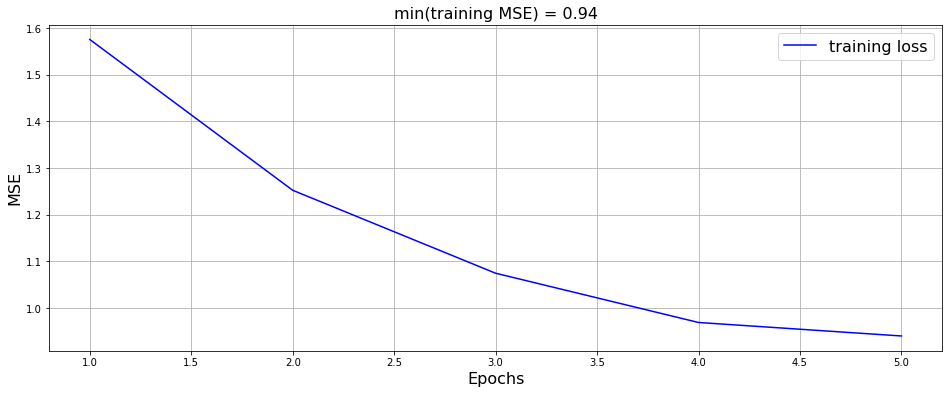

In [40]:
def plot_train_loss(history, num_epochs=n_epochs):
    train_loss = history.history['mse']
    plt.figure(figsize=(16,6))
    plt.plot(range(1,num_epochs+1), train_loss, 'b', label='training loss',color="blue")

    plt.title('min(training MSE) = ' + str(round(min(train_loss),3)),fontsize=16)
    plt.xlabel('Epochs',fontsize=16)
    plt.ylabel('MSE',fontsize=16)
    plt.grid(True)
    plt.legend(loc = 'upper right',fontsize=16)

    plt.show()
    
plot_train_loss(history)

In [41]:
predictions = model.predict(Xs)

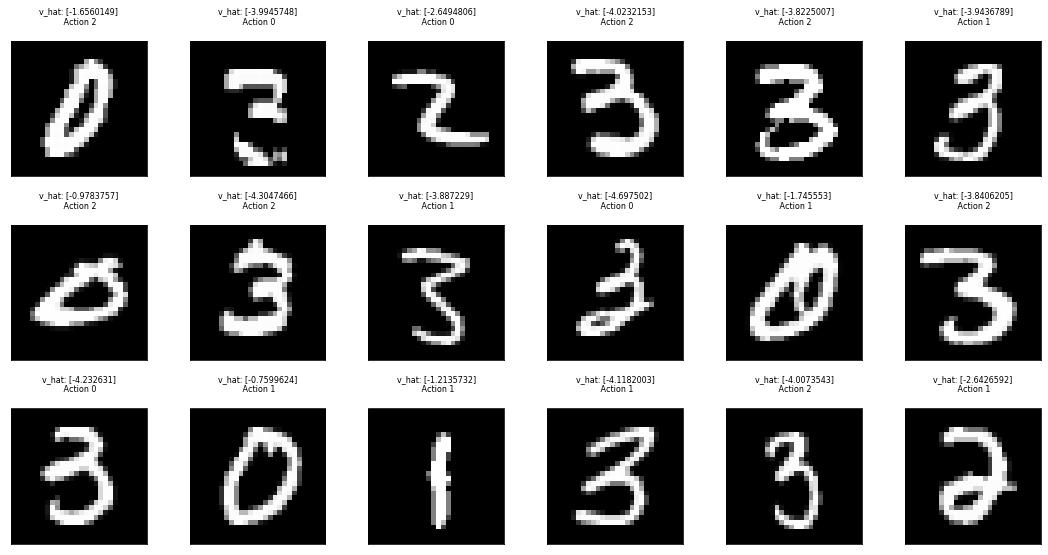

In [42]:
random.seed(12545)
def plot_18(predictions, actions, v_hat):
    fig = plt.figure(figsize=(15,8))
    for i in range(18):
        img = random.randint(0,images.shape[0])
        plt.subplot(3,6,i+1)
        plt.tight_layout()
        plt.imshow(images[img].reshape((-1,28,28))[0], cmap='gray', interpolation='none')
        plt.title("v_hat: {}\n Action {}\n".format(predictions[img], actions[img]),fontsize=8)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
plot_18(predictions, actions, v_hat)

To estimate v_hat for each state, we can try clustering the predictions into the 4 states.

In [43]:
random.seed(1234)
kmeans = KMeans(n_clusters=4)

In [44]:
cluster = kmeans.fit_predict(predictions)#.reshape(-1,1)

In [45]:
sorted(kmeans.cluster_centers_)

[array([-4.351221], dtype=float32),
 array([-3.7452095], dtype=float32),
 array([-2.464982], dtype=float32),
 array([-0.9549438], dtype=float32)]

We can see this roughly fits with what we observe in the images. V_hat is around -4 for 3, -3 for state 2, -2 for state 1 and -1 for state 0.

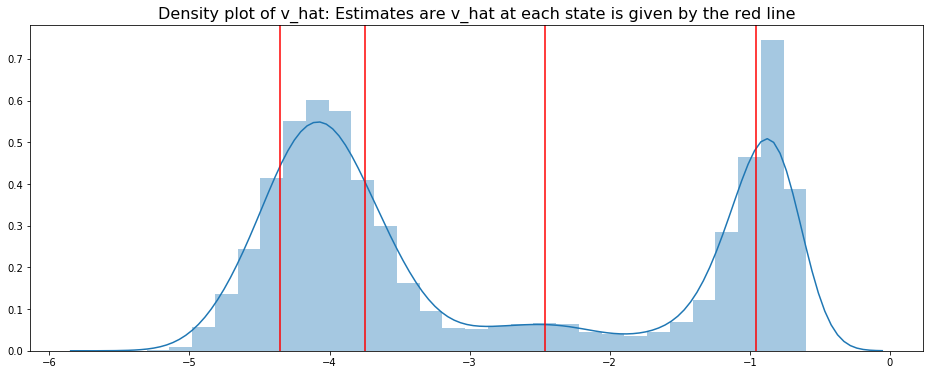

In [46]:
plt.figure(figsize=(16,6))
plt.title('Density plot of v_hat: Estimates are v_hat at each state is given by the red line',fontsize=16)
sns.distplot((predictions))
for xc in kmeans.cluster_centers_:
    plt.axvline(x=xc, color="r")
plt.show()

# Part 1 Checks

In [47]:
W = np.array([np.array([[-.8, .2, .3, .9],[.3, -.5, -.2, -.4]]), np.array([.1, -.3, 1.4])])

assert all(W[1] == np.array([ 0.1, -0.3,  1.4]))
assert all(W[0][0] == np.array([-.8, .2,.3, .9]))
assert all(W[0][1] == np.array([.3, -.5,-.2, -.4]))

In [48]:
x = np.array([1, 1.2, .4, .3])

In [49]:
leaky_relu = lambda x: np.where(x > 0, x, x * 0.1) 

In [50]:
def leaky_relu_dv(x, alpha=0.1):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

In [51]:
def forward_and_back(W, x, v_pi=3.2, alpha=.1):
    #hidden layer 1
    z1 = np.dot(W[0][0], x)
    u1 = leaky_relu(z1)
    print(f"z1: {z1}")
    print(f"u1: {u1}")

    #hidden layer 2
    z2 = np.dot(W[0][1], x)
    u2 = leaky_relu(z2)
    print(f"z2: {z2}")
    print(f"u2: {u2}")
    
    #output layer
    u = np.array([1, u1, u2])
    z = np.dot(W[1], u)
    v_hat = leaky_relu(z)
    print(f"u: {u}")
    print(f"z: {z}")
    print(f"v_hat: {v_hat}")
    #assert round(v_hat,3) == 2.276
    
    #errors output layer
    e = v_hat - v_pi
    print(f"e:{e}")
    #assert round(e, 3) == -1.824
    
    #errors hidden layer 1
    e1 = np.dot(e,np.dot(leaky_relu_dv(z2),W[1][1]))
    print(f"w1:{W[1][1]}")
    print(f"e1:{e1}")
    #assert round(e1, 4) == 1.4592
    
    #errors hidden layer 2
    e2 = np.dot(e,np.dot(leaky_relu_dv(z2),W[1][2]))
    print(f"w2:{W[1][2]}")
    print(f"e2:{e2}")
    #assert round(e2, 4) == -2.1888
    
    #partial derv output layer
    dv = np.dot(e, leaky_relu_dv(z) * u)
    print(f"dv:{dv}")
    #assert dv == approx(np.array([-1.824, 0., -3.15552]))
    
    #derivative for hidden layer 1
    dv1 = np.dot(e1, np.dot(leaky_relu_dv(z1), x))
    print(f"dv1:{dv1}")
    #assert dv1 == approx(np.array([0.,0.,0.]))
    
    dv2 = np.dot(e2, np.dot(leaky_relu_dv(z2), x))
    print(f"dv2:{dv2}")
    #assert dv2 == approx(np.array([-2.1888,-2.84544,-1.53216]))
    
    #sgd update
    w = np.concatenate((W[0][0], W[0][1], W[1]))
    print(f"w: {w}")
    deltaL = np.concatenate((dv1, dv2, dv), axis=0)
    print(f"delta: {deltaL}")
    update = w - alpha * deltaL
    print(f"update:{update}")
    #assert update == approx(np.array([-1.2, 0.1, 0.5, 1.11888, 1.084544, -0.146784, 0.3824, -0.8, 1.515552]))
    
    
forward_and_back(W,x)    

z1: -0.17000000000000004
u1: -0.017000000000000005
z2: -0.5
u2: -0.05
u: [ 1.    -0.017 -0.05 ]
z: 0.03510000000000002
v_hat: 0.03510000000000002
e:-3.1649000000000003
w1:-0.3
e1:0.094947
w2:1.4
e2:-0.443086
dv:[-3.1649     0.0538033  0.158245 ]
dv1:[0.0094947  0.01139364 0.00379788 0.00284841]
dv2:[-0.0443086  -0.05317032 -0.01772344 -0.01329258]
w: [-0.8  0.2  0.3  0.9  0.3 -0.5 -0.2 -0.4  0.1 -0.3  1.4]
delta: [ 9.494700e-03  1.139364e-02  3.797880e-03  2.848410e-03 -4.430860e-02
 -5.317032e-02 -1.772344e-02 -1.329258e-02 -3.164900e+00  5.380330e-02
  1.582450e-01]
update:[-0.80094947  0.19886064  0.29962021  0.89971516  0.30443086 -0.49468297
 -0.19822766 -0.39867074  0.41649    -0.30538033  1.3841755 ]
